## imports

In [ ]:
from torchvision import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch import Tensor
from torch.optim.optimizer import Optimizer
import numpy as np
import matplotlib.pyplot as plt
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Loading MNIST dataset

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

train_data = datasets.MNIST(root= 'data', train= True, transform= transform, download= True)
test_data = datasets.MNIST(root= 'data', train= False, transform= transform, download= True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle= True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle= True)

print(train_data,'\n', test_data)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           ) 
 Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


### visuaizing dataset

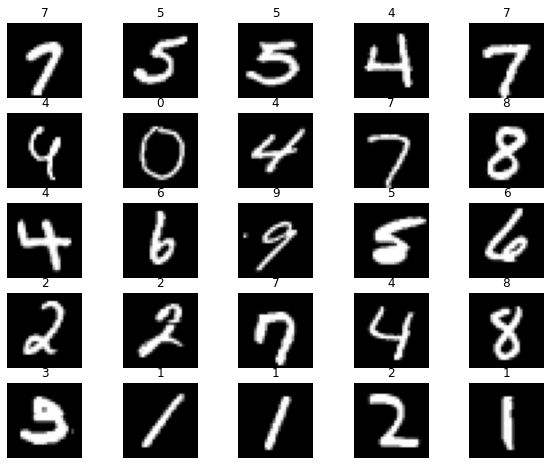

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

##CNN model

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Sequential(
                  nn.Conv2d(in_channels= 1, out_channels= 6, kernel_size= 5, stride= 1, padding= 2),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size= 2)
    )
    self.conv2 = nn.Sequential(
                  nn.Conv2d(6,32,5,1,2),
                  nn.ReLU(),
                  nn.MaxPool2d(2)
    )

    self.out = nn.Sequential(
                nn.Linear(32*7*7,128),
                nn.ReLU(),
                nn.Linear(128, 10)
    )
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)

    # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
    x = x.view(x.size(0), -1)
    output = self.out(x)
    return output

## training with ADAM and SGD optimizers

In [ ]:
def test(model, test_loader):
      model.train(False) # Don't need to track gradients for validation
      correct = 0
      vloss = 0.0
      for j, vdata in enumerate(test_loader, 0):
            X, y = vdata
            X, y = X.to(device), y.to(device)
            pred = model(X)
            vloss += loss_func(pred, y).item()
            pred = torch.argmax(pred , dim = 1)
            correct += (pred == y).float().sum()

      accuracy = 100 * correct / len(test_loader.dataset)
      return accuracy.item() , vloss/len(test_loader)

In [ ]:
def train(model, train_loader, loss_func, optimizer, epoch):

  model.train()
  epoch_loss= []
  for batch , (images,labels) in enumerate(train_loader):

    images , labels = images.to(device) , labels.to(device)

    output = model(images)
    loss = loss_func(output, labels)
    epoch_loss.append(loss.item())
  
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return sum(epoch_loss) / len(epoch_loss)


In [ ]:
epochs = 10
cnn = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
ADAM = optim.Adam(cnn.parameters(), lr = 0.005)
ADAM_loss = []
ADAM_test_acc = [] 
ADAM_vloss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    ADAM_loss.append(train(cnn,train_loader, loss_func, ADAM,t))
    print('train loss: ', ADAM_loss[-1])
    test_acc , vloss = test(cnn, test_loader)
    print('test acc, validation loss : ', test_acc , vloss)
    ADAM_test_acc.append(test_acc)
    ADAM_vloss.append(vloss)
print("Done!")

Epoch 1
-------------------------------
train loss:  0.18375060912617977
test acc, validation loss :  98.55999755859375 0.040809385714237575
Epoch 2
-------------------------------
train loss:  0.04487188872584003
test acc, validation loss :  98.68000030517578 0.03196278415562119
Epoch 3
-------------------------------
train loss:  0.033117772510988595
test acc, validation loss :  98.93999481201172 0.03161041541025043
Epoch 4
-------------------------------
train loss:  0.026708340546750326
test acc, validation loss :  98.82999420166016 0.0314473774182261
Epoch 5
-------------------------------
train loss:  0.02065906787360523
test acc, validation loss :  99.0 0.031194167473586276
Epoch 6
-------------------------------
train loss:  0.01797140648469646
test acc, validation loss :  98.93000030517578 0.03501008498715237
Epoch 7
-------------------------------
train loss:  0.016810991441177085
test acc, validation loss :  99.1199951171875 0.032640905309972365
Epoch 8
---------------------

In [ ]:
epochs = 20
cnn = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
SGD = optim.SGD(cnn.parameters(), lr = 0.005)
SGD_loss = []
SGD_test_acc = [] 
SGD_vloss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    SGD_loss.append(train(cnn,train_loader, loss_func, SGD,t))
    print('train loss: ', SGD_loss[-1])
    test_acc , vloss = test(cnn, test_loader)
    print('test acc, validation loss : ', test_acc , vloss)
    SGD_test_acc.append(test_acc)
    SGD_vloss.append(vloss)
print("Done!")

Epoch 1
-------------------------------
train loss:  2.2448140255948332
test acc, validation loss :  47.03999710083008 2.150981682538986
Epoch 2
-------------------------------
train loss:  1.785309847872308
test acc, validation loss :  77.15999603271484 1.1313601911067963
Epoch 3
-------------------------------
train loss:  0.7281850268232062
test acc, validation loss :  85.29000091552734 0.4969514712691307
Epoch 4
-------------------------------
train loss:  0.4410137161295465
test acc, validation loss :  87.5199966430664 0.37952533531934024
Epoch 5
-------------------------------
train loss:  0.3530924266957222
test acc, validation loss :  88.45999908447266 0.3691477417945862
Epoch 6
-------------------------------
train loss:  0.298766147266043
test acc, validation loss :  91.90999603271484 0.26662828736007216
Epoch 7
-------------------------------
train loss:  0.26058103505601277
test acc, validation loss :  93.05999755859375 0.23480917662382125
Epoch 8
--------------------------

##hybrid PSO

### hybrid PSO optimizer

In [ ]:
class hybrid_PSO(Optimizer):

  def __init__(self, params, W_max, W_min, C1, C2, T_max):

    defaults = dict(W_max=W_max, W_min=W_min, C1= C1, C2= C2)
    self.iter = 0
    self.T_max = T_max
    super(hybrid_PSO, self).__init__(params, defaults)

  @torch.no_grad()
  def step(self, best_idx, min_loss , closure=None):
      """Performs a single optimization step.
      Args:
          closure (callable, optional): A closure that reevaluates the model
              and returns the loss.
      """
      loss = None
      if closure is not None:
          with torch.enable_grad():
              loss = closure()
      #for each particle(model)

      if 'best_idx' not in self.state:
        self.state['best_idx'] = best_idx
        self.state['min_loss'] = min_loss
        self.state['best_position'] = self.param_groups[best_idx]['params']
        self.state['best iter'] = 0

      else:
        if min_loss < self.state['min_loss']:
            print('idx changed-------------------------------------', best_idx)
            self.state['best_idx'] = best_idx
            self.state['min_loss'] = min_loss
            self.state['best_position'] = self.param_groups[best_idx]['params']
            self.state['best iter'] = 0
        else:
            self.state['best iter'] += 1

      
      best_params = self.state['best_position']


      for group in self.param_groups:

        rp = 1.0 #random.uniform(0,1)
        rg = random.uniform(0,1)

        W = group['W_max'] - (((group['W_max'] - group['W_min']) * self.iter)/self.T_max)
        C1 = group['C1'] #* max((1 - self.iter/self.T_max),0.1)
        C2 = group['C2'] * (1 + (self.state['best iter']/self.T_max)) #+ (self.iter/self.T_max))

        for (p, best_p) in zip(group['params'],best_params):

            if p.grad is None:
              continue

            param_state = self.state[p]
            if 'V' not in param_state:
              param_state['V'] = torch.randn_like(p.data)

            d_p = p.grad
            norm_d_p =  torch.linalg.norm(p.grad)
            d_p.div_(torch.pow(norm_d_p , 2))

            V = param_state['V']
            V.mul_(W)
            V.add_(d_p, alpha=-C1*rp)
            
            group_exp = best_p.data - p.data
            V.add_( group_exp, alpha = C2*rg)
            self.state[p]['V'] = V

            p.data.add_(V)

      self.iter+=1
      return loss

## training with hybrid PSO

In [ ]:
def train_pso(models, train_loader, loss_func, optimizer):

  losses = [0.0 for model in models]
  min_loss = 10**10
  best_idx = 0

  for batch , (images,labels) in enumerate(train_loader):

    images , labels = images.to(device) , labels.to(device)
    for idx ,model in enumerate(models):
        model.train()
        output = model(images)
        loss = loss_func(output, labels)
        loss.backward()
        losses[idx]+=loss.item()
        if losses[idx]/(batch+1) <= min_loss:
            best_idx = idx
            min_loss = losses[idx]/(batch+1)
            
    optimizer.step(best_idx, min_loss)
    optimizer.zero_grad()
  
  return min(losses)/len(train_loader) , sum(losses)/(len(losses)*len(train_loader))


In [ ]:
T_max = 30
num_particles = 10
models = [CNN().to(device) for i in range(num_particles)]
loss_func = nn.CrossEntropyLoss() 

pso_opt = hybrid_PSO([{'params':model.parameters()} for model in models],
                     W_max = 0.1, W_min = 0.01, C1 = 0.01 , C2 = 0.01, T_max = T_max * len(train_loader))

PSO_min_loss2 = []
PSO_test_acc2 = []
PSO_mean_loss2 = []
PSO_vloss2 = []
epochs = T_max
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    min_loss , mean_loss = train_pso(models,train_loader, loss_func, pso_opt)
    PSO_min_loss2.append(min_loss)
    PSO_mean_loss2.append(mean_loss)
    print('min loss: ', min_loss)
    print('mean loss: ', mean_loss)
    models_acc=[]
    models_val = []
    for model in models:
      test_acc , vloss = test(model, test_loader)
      models_acc.append(test_acc)
      models_val.append(vloss)
    best_test_acc = max(models_acc)
    best_val_loss = min(models_val)
    print('models acc: ',models_acc )
    print('best test acc: ',best_test_acc)
    print('best val acc: ',best_val_loss)
    PSO_test_acc2.append(best_test_acc)
    PSO_vloss2.append(best_val_loss)
print("Done!")

Epoch 1
-------------------------------
idx changed------------------------------------- 5
idx changed------------------------------------- 5
idx changed------------------------------------- 5
idx changed------------------------------------- 5
idx changed------------------------------------- 5
idx changed------------------------------------- 5
idx changed------------------------------------- 5
idx changed------------------------------------- 5
idx changed------------------------------------- 5
idx changed------------------------------------- 5
idx changed------------------------------------- 5
idx changed------------------------------------- 5
idx changed------------------------------------- 5
idx changed------------------------------------- 5
idx changed------------------------------------- 5
idx changed------------------------------------- 5
idx changed------------------------------------- 5
idx changed------------------------------------- 5
idx changed-------------------------------

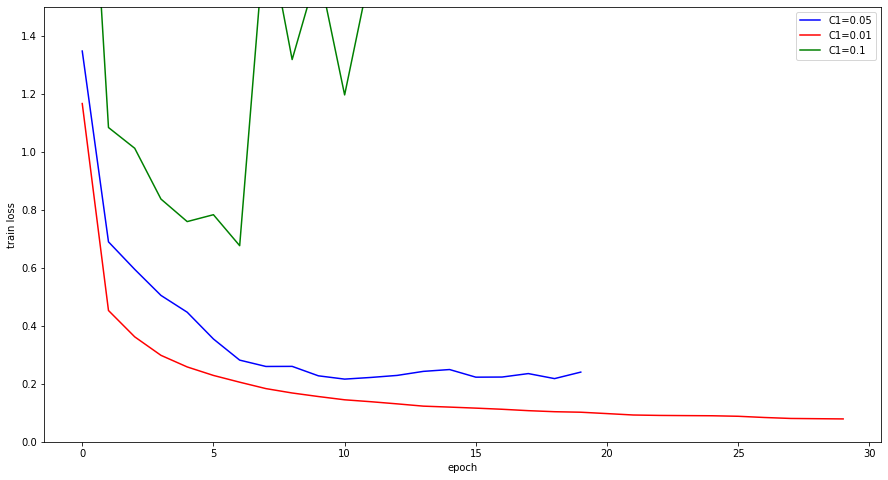

In [85]:
plt.figure(figsize=(15,8))
#plt.plot(PSO_min_loss3_, '-b', label='C1=0.05')
plt.plot(PSO_min_loss2, '-r', label='C1=0.01')
#plt.plot(PSO_min_loss1, '-g', label='C1=0.1')


plt.xlabel("epoch")
plt.ylabel('train loss')
plt.legend(loc='upper right')
#plt.title('title')
ax = plt.gca()
#ax.set_xlim([xmin, xmax])
ax.set_ylim([0, 1.5])
# save image
#plt.savefig(title+".png")  # should before show method

# show
plt.show()

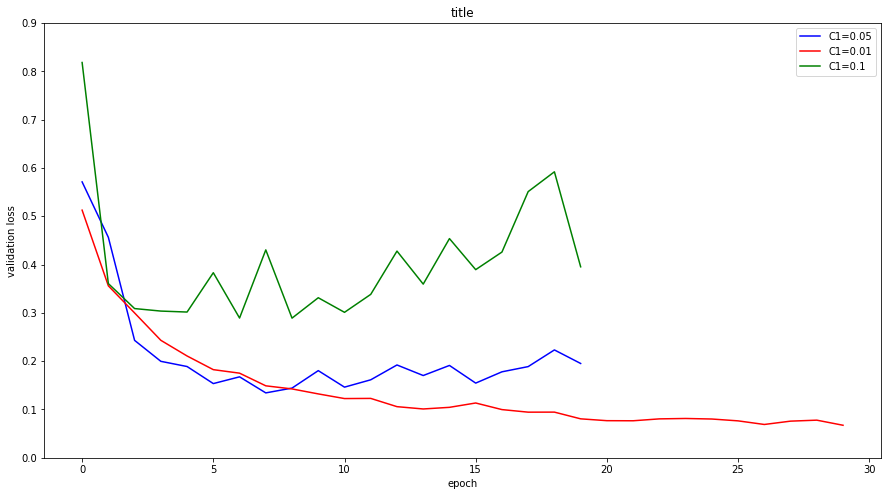

In [86]:
plt.figure(figsize=(15,8))
#plt.plot(PSO_vloss3_, '-b', label='C1=0.05')
plt.plot(PSO_vloss2, '-r', label='C1=0.01')
#plt.plot(PSO_vloss1, '-g', label='C1=0.1')


plt.xlabel("epoch")
plt.ylabel('validation loss')
plt.legend(loc='upper right')
plt.title('title')
ax = plt.gca()
#ax.set_xlim([xmin, xmax])
ax.set_ylim([0, 0.9])
# save image
#plt.savefig(title+".png")  # should before show method

# show
plt.show()

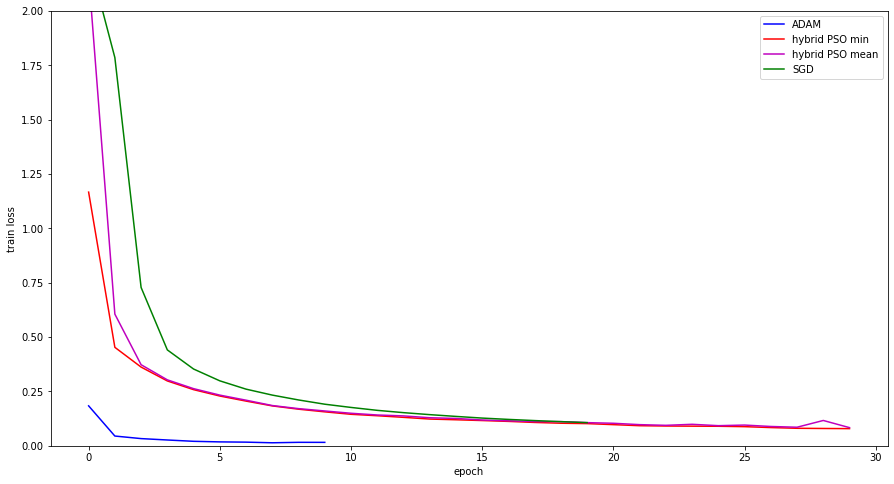

In [87]:
plt.figure(figsize=(15,8))
plt.plot(ADAM_loss, '-b', label='ADAM')
plt.plot(PSO_min_loss2, '-r', label='hybrid PSO min')
plt.plot(PSO_mean_loss2, '-m', label='hybrid PSO mean')
plt.plot(SGD_loss, '-g', label='SGD')


plt.xlabel("epoch")
plt.ylabel('train loss')
plt.legend(loc='upper right')
#plt.title('title')
ax = plt.gca()
#ax.set_xlim([xmin, xmax])
ax.set_ylim([0, 2])
# save image
#plt.savefig(title+".png")  # should before show method

# show
plt.show()

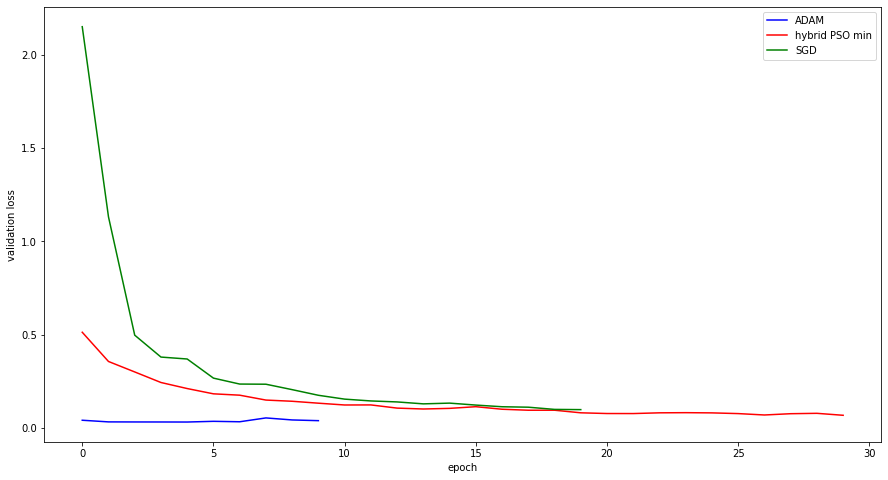

In [88]:
plt.figure(figsize=(15,8))
plt.plot(ADAM_vloss, '-b', label='ADAM')
plt.plot(PSO_vloss2, '-r', label='hybrid PSO min')
plt.plot(SGD_vloss, '-g', label='SGD')


plt.xlabel("epoch")
plt.ylabel('validation loss')
plt.legend(loc='upper right')
#plt.title('title')
ax = plt.gca()
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([0, 1])
# save image
#plt.savefig(title+".png")  # should before show method

# show
plt.show()

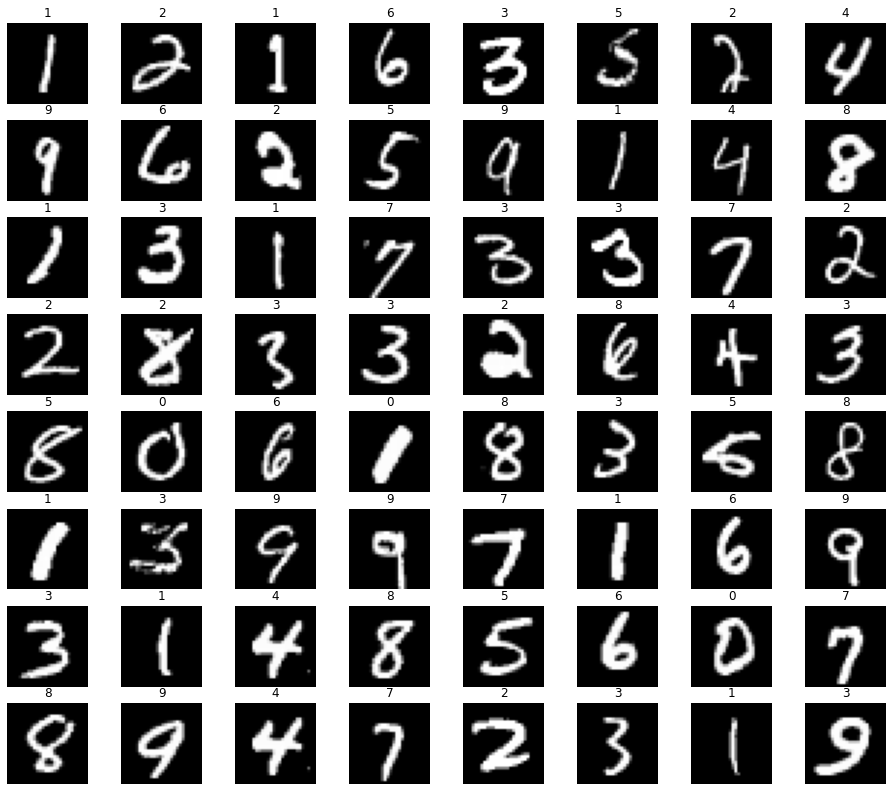

In [ ]:
figure = plt.figure(figsize=(16, 14))
cols, rows = 8, 8
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    pred = models[2](img.to(device).unsqueeze(0))
    pred.squeeze_()
    plt.title(torch.argmax(pred).item())
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()